In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from database_tools import PandasDBReader
from sklearn.ensemble import RandomForestRegressor
from fh_config import regional_options, specialty_options, regression_vars, response_var, fraudulent_npis
from anomaly_tools import AnomalyDetector, KMeansAnomalyDetector, HDBAnomalyDetector
from pyearth import Earth
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

In [2]:
YAML_CONFIG = "./config.yaml"

In [3]:
# Query the database.
states = ['FL']
specialty = ['Cardiology']
pdb_reader = PandasDBReader(YAML_CONFIG, states, specialty)

In [4]:
# Create an AnomalyDetector to get the matrix.
a_detector = AnomalyDetector(regression_vars, response_var, pdb_reader.d_f, use_response_var=False)

In [9]:
print(a_detector.d_f.sort_values(by='line_srvc_cnt', ascending=False).head(50))

               npi nppes_provider_city nppes_provider_last_org_name  \
140529  1033145487               OCALA                        QAMAR   
26425   1588657381               OCALA                        REDDY   
73110   1588657381               OCALA                        REDDY   
15294   1316983232               OCALA                        FERNS   
56642   1225078124            SARASOTA                        MYERS   
140655  1033145487               OCALA                        QAMAR   
56491   1225058357      PORT CHARLOTTE                   ROSENFIELD   
140401  1033145487               OCALA                        QAMAR   
37967   1821192501             ORLANDO                 VAN DEN BERG   
85343   1821192501             ORLANDO                 VAN DEN BERG   
86877   1861485757            LEESBURG                          LEW   
39525   1861485757            LEESBURG                          LEW   
134960  1891757811             BRANDON                        BUGNI   
133898

In [42]:
column_list = [var for var in regression_vars]
column_list.append(response_var)
fig = plt.figure(figsize=(40, 15))
ax = fig.add_subplot(111)
sub_df = a_detector.d_f[column_list]
sub_df.boxplot(showfliers=True, figsize=(40, 15), ax=ax)
plt.yscale('log')
plt.grid(False)
plt.rc('ytick', labelsize=50)
plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.yaxis.set_tick_params(length=10, which='both')
plt.savefig("/home/dan/boxplots.pdf")
# plt.show()

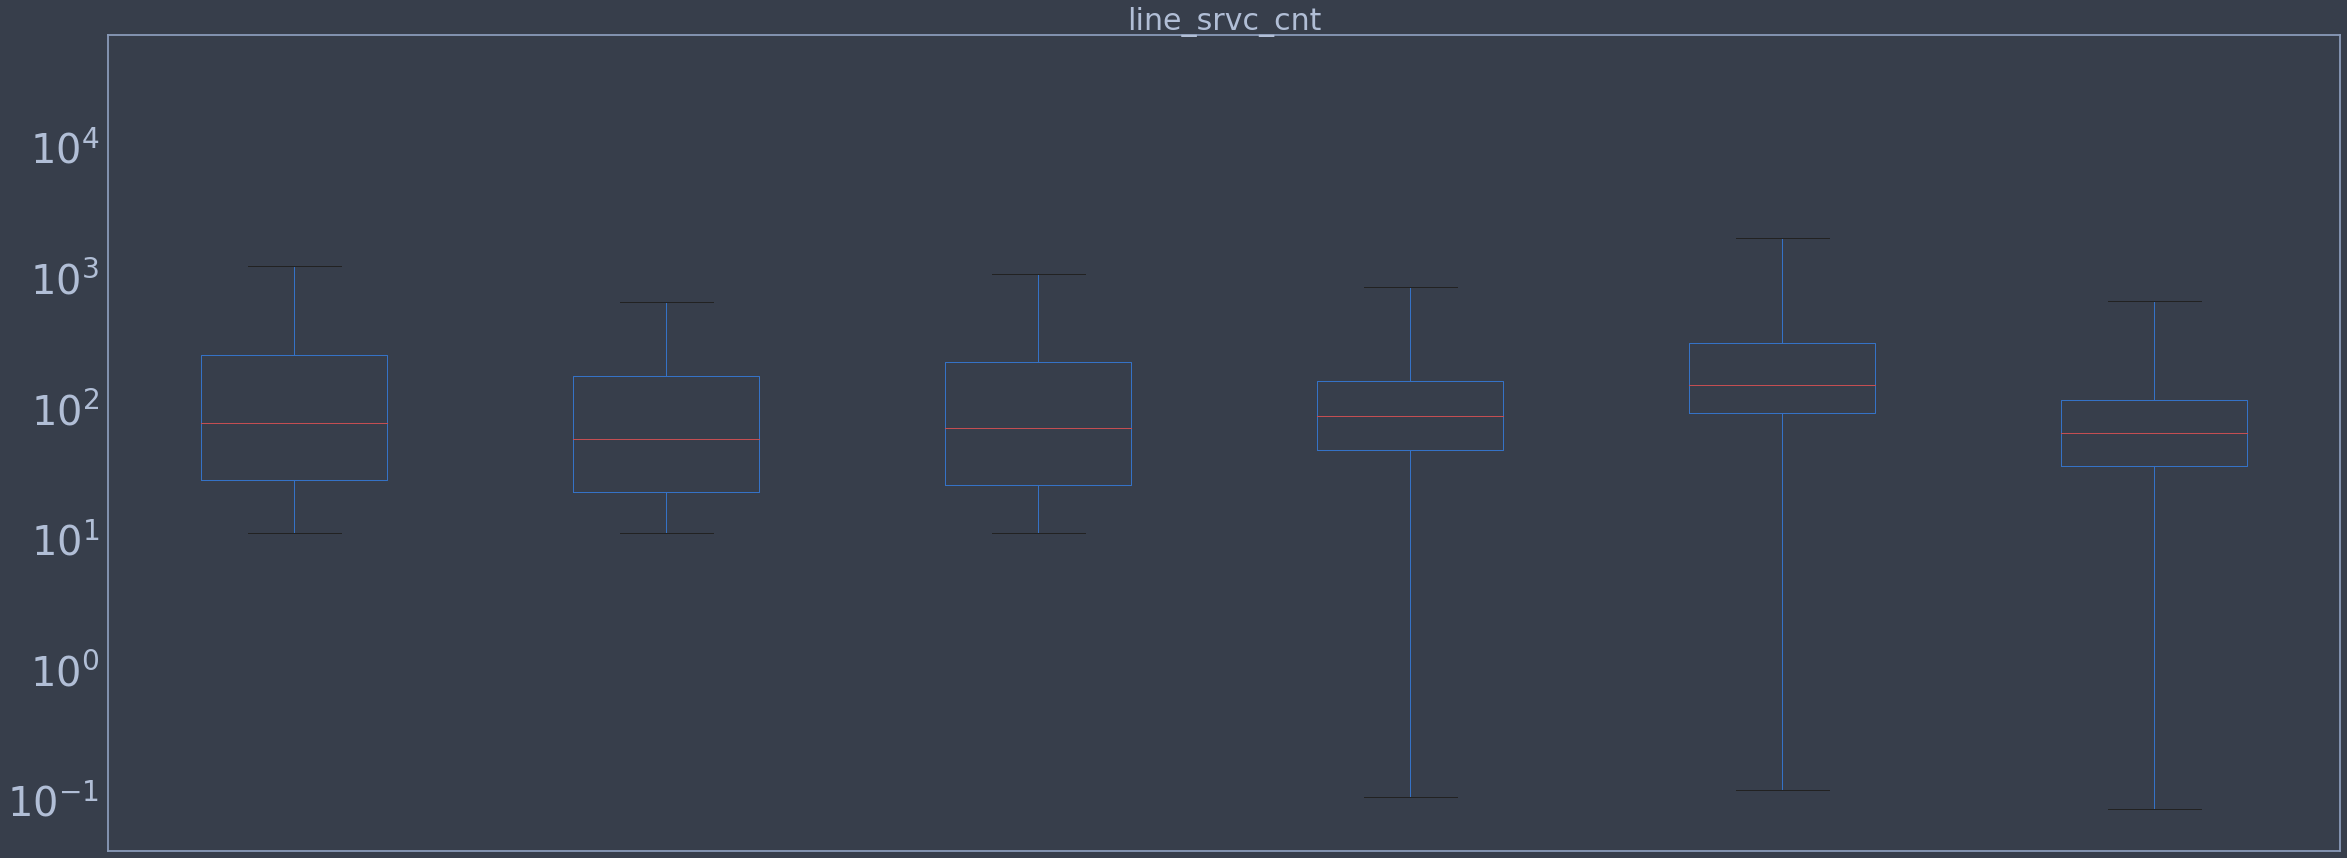

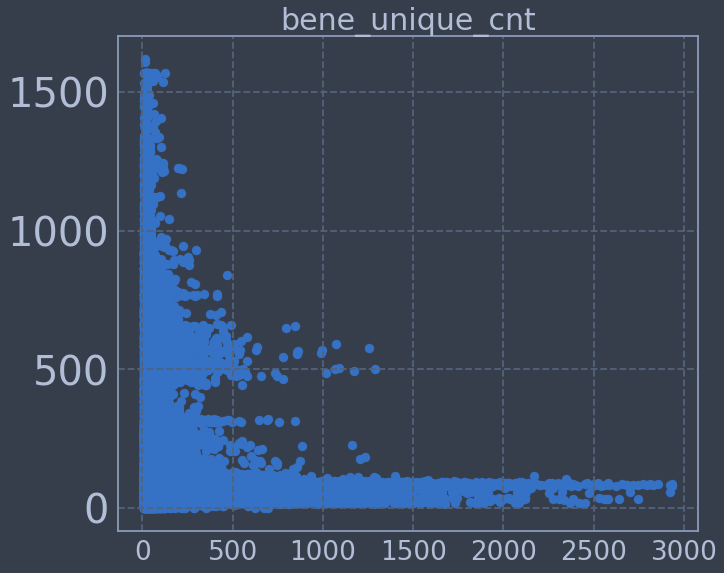

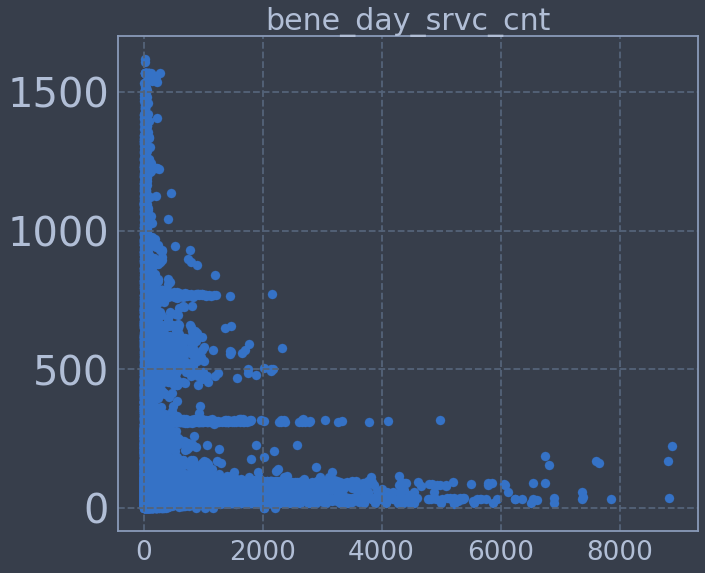

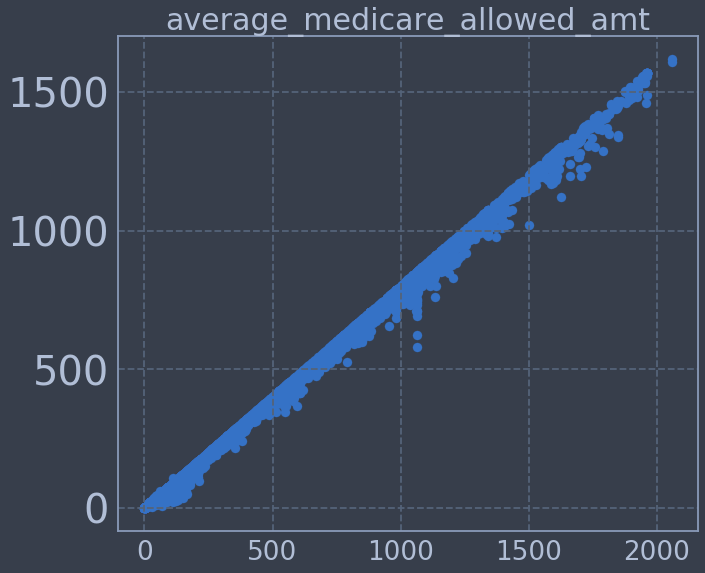

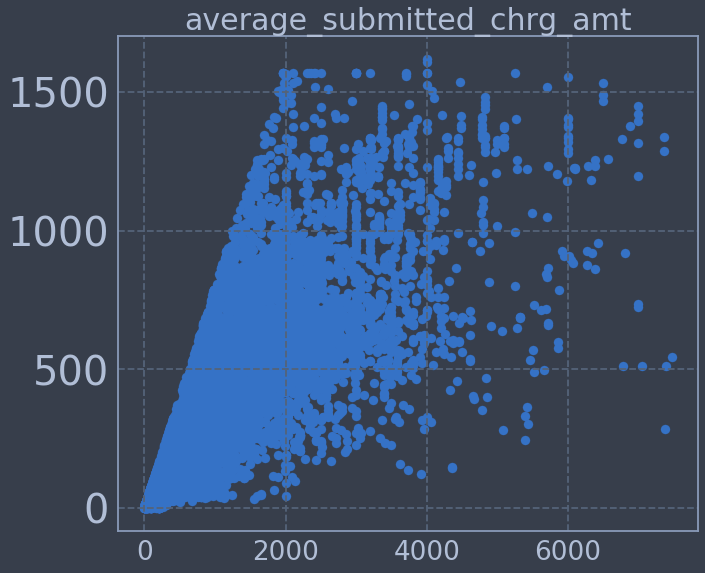

In [16]:
# Just checking correlation between allowed and paid...
for regvar in regression_vars:
    plt.scatter(a_detector.d_f[regvar].values, a_detector.d_f[response_var].values)
    plt.title(regvar)
    plt.show()
    plt.gcf().clear()

In [55]:
# Trying feature selection with MARS
criteria = ('rss', 'gcv', 'nb_subsets')
model = Earth(max_degree=3, max_terms=10, minspan_alpha=0.5, feature_importance_type=criteria, verbose=True)

# Defining shorter variables for simplicity and consistency
X = a_detector.data_matrix
y = a_detector.d_f[response_var].values

# Actual fit
model.fit(X, y)
# rf = RandomForestRegressor()
# rf.fit(X, y)

y_hat = model.predict(X)
num_pts = [i for i in range(len(y_hat))]
plt.gcf().clear()
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
ax.scatter(num_pts, y-y_hat, s=120, edgecolor='black', linewidth=2.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.rc('ytick', labelsize=50)
plt.rc('xtick', labelsize=50)
# Plot the importances
# importances = model.feature_importances_
# importances['random_forest'] = rf.feature_importances_
# criteria = criteria + ('random_forest',)
# idx = 1
# fig = plt.figure()
# for crit in criteria:
#     plt.subplot(2, 2, idx)
#     plt.bar(np.arange(len(regression_vars)), importances[crit], align='center')
#     plt.xticks(np.arange(len(regression_vars)), regression_vars, rotation=270)
#     plt.ylabel('importances')
#     idx += 1
plt.savefig("/home/dan/mv_outliers.pdf")

Beginning forward pass
---------------------------------------------------------------------
iter  parent  var  knot  mse          terms  gcv       rsq    grsq   
---------------------------------------------------------------------
0     -       -    -     4820.183660  1      4820.226  0.000  0.000  
1     0       3    182640  58.441303  3      58.444  0.988  0.988  
2     1       4    110262  57.644769  5      57.650  0.988  0.988  
-------------------------------------------------------------------
Stopping Condition 2: Improvement below threshold
Beginning pruning pass
----------------------------------------------
iter  bf  terms  mse    gcv     rsq    grsq   
----------------------------------------------
0     -   5      57.64  57.650  0.988  0.988  
1     3   4      57.67  57.676  0.988  0.988  
2     4   3      58.44  58.444  0.988  0.988  
3     2   2      810.10  810.127  0.832  0.832  
4     1   1      4820.18  4820.226  0.000  0.000  
--------------------------------------

In [26]:
# Now creating a K-means anomaly detector
kmd = KMeansAnomalyDetector(regression_vars, response_var, pdb_reader.d_f, use_response_var=True)

In [27]:
kmd.compute_centroid_distances(num_clusters=8)

In [28]:

model2 = Earth()
model.fit(kmd.data_matrix, pdb_reader.d_f[response_var].values)

Beginning forward pass
---------------------------------------------------------------------
iter  parent  var  knot  mse          terms  gcv       rsq    grsq   
---------------------------------------------------------------------
0     -       -    -     4820.183660  1      4820.226  0.000  0.000  
1     0       5    66143  -0.000000  3      -0.000  1.000  1.000  
------------------------------------------------------------------
Stopping Condition 1: Achieved RSQ value within threshold of 1
Beginning pruning pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   3      0.00  0.000  1.000  1.000  
1     2   2      0.00  0.000  1.000  1.000  
2     1   1      4820.18  4820.226  0.000  0.000  
--------------------------------------------------
Selected iteration: 0


Earth(allow_linear=None, allow_missing=False, check_every=None,
   enable_pruning=True, endspan=None, endspan_alpha=None, fast_K=None,
   fast_h=None, feature_importance_type=('rss', 'gcv', 'nb_subsets'),
   max_degree=3, max_terms=10, min_search_points=None, minspan=None,
   minspan_alpha=0.5, penalty=None, smooth=None, thresh=None,
   use_fast=None, verbose=True, zero_tol=None)

In [4]:
unique_npis_in_db = pdb_reader.d_f['npi'].unique()
print(len(unique_npis_in_db))
fraud_strings = [str(npi) for npi in fraudulent_npis]
frauds_truth = set(list(unique_npis_in_db)).intersection(fraud_strings)
print(frauds_truth)

1803
{'1033145487'}


In [22]:
top_n_vals = []
num_caught = []
most_frequent_ranked = kmd.get_most_frequent()
for n in range(10,6000):
    most_frequent_npids = [str(npid) for npid in (most_frequent_ranked.head(n).index)]
    found = set(most_frequent_npids).intersection(frauds_truth)
    top_n_vals.append(n)
    num_caught.append(len(found))
plt.scatter(top_n_vals, num_caught)

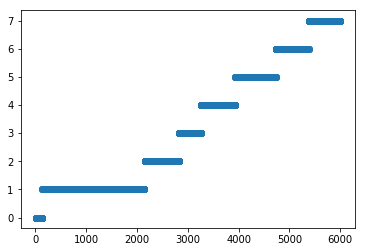

In [23]:
plt.show()

In [5]:
# Testing the HDB Anomaly detector
hdb = HDBAnomalyDetector(regression_vars, response_var, pdb_reader.d_f, use_response_var=True)

In [8]:
fitted = hdb.cluster_data(15)

In [13]:
threshold = pd.Series(fitted.outlier_scores_).quantile(0.999)
outliers = np.where(fitted.outlier_scores_ > threshold)[0]

In [17]:
plt.gcf().clear()
# pca = PCA(n_components=2)
# output = pca.fit_transform(hdb.scaled_dm)
# print("Number of outliers " + str(len(outliers)))
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
ax.scatter(hdb.d_f['average_submitted_chrg_amt'].values, hdb.d_f['line_srvc_cnt'].values, edgecolor='black', linewidth=2, s=150, color='grey')
ax.scatter(hdb.d_f['average_submitted_chrg_amt'].values[outliers], hdb.d_f['line_srvc_cnt'].values[outliers], color='red', edgecolor='black', linewidth=2, s=150)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.rc('ytick', labelsize=50)
plt.rc('xtick', labelsize=50)
# plt.ylim([0,5000])
# plt.xlim([0,4000])
plt.yscale('log')
plt.xscale('log')
plt.savefig("/home/dan/pca_cluster_mono_highlighted.pdf")
# plt.show()

Number of outliers 228


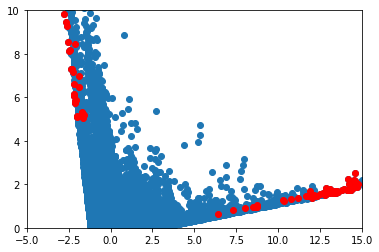

In [88]:
# How does K-means compare?
plt.gcf().clear()
output2 = pca.fit_transform(kmd.scaled_dm)
k_outlier_threshold = np.percentile(kmd.d_f['outlier_metric'].values, 99.9)
outliers2 = np.where(kmd.d_f['outlier_metric'] > k_outlier_threshold)[0]
print("Number of outliers " + str(len(outliers2)))
plt.scatter(output2[:,0], output2[:,1])
plt.scatter(output2[:,0][outliers2], output2[:,1][outliers2], color='red')
plt.ylim([0,10])
plt.xlim([-5,15])
plt.show()